In [21]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy, time
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
train_data = pd.read_csv('train_data.csv')
test_features = pd.read_csv('test_features.csv')
print(f'train_data shape: {train_data.shape}')
display(train_data.head())

print(f'test_features shape: {train_data.shape}')
display(test_features.head())                            

train_data shape: (113, 22)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


test_features shape: (113, 22)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,NaN,tim.belden@enron.com,953136.0,17355.0,484.0,228.0,...,NaN,NaN,210698.0,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0
1,BOWEN JR RAYMOND M,1350000.0,NaN,-833.0,NaN,raymond.bowen@enron.com,NaN,65907.0,27.0,140.0,...,NaN,974293.0,1621.0,252055.0,NaN,278601.0,1593.0,1858.0,2669589.0,252055.0
2,HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,...,NaN,1617011.0,11350.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
3,DELAINEY DAVID W,3000000.0,NaN,NaN,NaN,david.delainey@enron.com,2291113.0,86174.0,3069.0,66.0,...,NaN,1294981.0,1661.0,1323148.0,NaN,365163.0,2097.0,3093.0,4747979.0,3614261.0
4,CAUSEY RICHARD A,1000000.0,NaN,-235000.0,NaN,richard.causey@enron.com,NaN,30674.0,49.0,58.0,...,NaN,350000.0,307895.0,2502063.0,NaN,415189.0,1585.0,1892.0,1868758.0,2502063.0


## 資料前處理
### 1. 填補遺失值

In [4]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))

na_check(train_data)    

,Missing Ratio
loan_advances,98.230088
restricted_stock_deferred,91.150442
director_fees,88.495575
deferral_payments,75.221239
deferred_income,69.911504
long_term_incentive,56.637168
bonus,46.017699
from_messages,42.477876
from_poi_to_this_person,42.477876
from_this_person_to_poi,42.477876


In [5]:
'''
Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the
promissory notes allow for the option to repay with stock of the company.
高達98.23%無此資料，在觀察少數有此欄位的資料後，無明顯特徵，先予以刪除。
'''
display(train_data[~train_data.loan_advances.isnull()])

train_data = train_data.drop('loan_advances', axis = 1)
test_features = test_features.drop('loan_advances', axis = 1)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,...,3600000.0,10359729.0,True,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
110,PICKERING MARK R,300000.0,NaN,NaN,NaN,mark.pickering@enron.com,28798.0,31653.0,67.0,7.0,...,NaN,NaN,False,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0


In [6]:
'''
Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement. 
高達91.15%無此資料，在觀察少數有此欄位的資料後，目前有此發現:
1. poi皆為False
2. restricted_stock_deferred 幾乎全部為負值
暫時使用0填補。
'''
fill_col = ['restricted_stock_deferred', 'director_fees']
display(train_data[~train_data.restricted_stock_deferred.isnull()])
train_data[fill_col] = train_data[fill_col].fillna(0)
test_features[fill_col] = test_features[fill_col].fillna(0)

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
14,ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,NaN,phillip.allen@enron.com,1729541.0,13868.0,2195.0,47.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0
25,GATHMANN WILLIAM D,NaN,NaN,NaN,NaN,NaN,1753766.0,NaN,NaN,NaN,...,NaN,NaN,False,264013.0,-72419.0,NaN,NaN,NaN,NaN,1945360.0
50,BELFER ROBERT,NaN,-102500.0,NaN,3285.0,NaN,3285.0,NaN,NaN,NaN,...,NaN,NaN,False,NaN,44093.0,NaN,NaN,NaN,102500.0,-44093.0
57,PIPER GREGORY F,400000.0,1130036.0,-33333.0,NaN,greg.piper@enron.com,880290.0,43057.0,222.0,61.0,...,NaN,778.0,False,409554.0,-409554.0,197091.0,742.0,1238.0,1737629.0,880290.0
61,LOWRY CHARLES P,NaN,NaN,NaN,NaN,NaN,372205.0,NaN,NaN,NaN,...,NaN,NaN,False,153686.0,-153686.0,NaN,NaN,NaN,NaN,372205.0
68,HAEDICKE MARK E,1150000.0,2157527.0,-934484.0,NaN,mark.haedicke@enron.com,608750.0,76169.0,1941.0,180.0,...,983346.0,52382.0,False,524169.0,-329825.0,374125.0,1847.0,4009.0,3859065.0,803094.0
72,JAEDICKE ROBERT,NaN,NaN,-25000.0,108750.0,NaN,431750.0,NaN,NaN,NaN,...,NaN,NaN,False,44093.0,-44093.0,NaN,NaN,NaN,83750.0,431750.0
94,CLINE KENNETH W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,662086.0,-472568.0,NaN,NaN,NaN,NaN,189518.0
95,BANNANTINE JAMES M,NaN,NaN,-5104.0,NaN,james.bannantine@enron.com,4046157.0,56301.0,29.0,39.0,...,NaN,864523.0,False,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
99,NOLES JAMES L,NaN,774401.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,463261.0,-94556.0,NaN,NaN,NaN,774401.0,368705.0


In [7]:
fill_col = ['deferral_payments', 'deferred_income', 'long_term_incentive', 'bonus']
train_data[fill_col].plot()

In [8]:
'''
Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions
高達75.22%無此資料，觀察有值的資料後，目前有此發現:
1. poi有True有False
2. deferral_payments 分布分散。
groupby poi 使用分組中位數填補
'''

fill_col = ['deferral_payments', 'deferred_income', 'long_term_incentive', 'bonus']
for col in fill_col:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_features[col] = test_features[col].fillna(test_features[col].mode()[0])

In [9]:
# from_messages, from_poi_to_this_person, from_this_person_to_poi, to_messages 遺失比例相同，推測有關聯
fill_col = ["from_messages", "from_poi_to_this_person", "from_this_person_to_poi", "to_messages", "shared_receipt_with_poi"]
for col in fill_col:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_features[col] = test_features[col].fillna(test_features[col].mode()[0])

In [10]:
# missing 比例稍高，皆先用0取代。
fill_col = ["other", "salary", "expenses", "exercised_stock_options", "restricted_stock"]
for col in fill_col:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_features[col] = test_features[col].fillna(test_features[col].mode()[0])

In [11]:
# train_data["email_address"] = train_data["email_address"].fillna("Nan")
# test_features["email_address"] = test_features["email_address"].fillna("Nan")

# train_data["email_address"] = train_data["email_address"].fillna("None.")
# test_features["email_address"] = test_features["email_address"].fillna("None.")

# train_data["first_name"] = train_data["email_address"].apply(lambda x: x[:x.find('.')])
# train_data["first_name"] = train_data["email_address"].apply(lambda x: x[:x.find('.')])

In [12]:
train_data = train_data.drop("email_address", axis=1)
test_features = test_features.drop("email_address", axis=1)

In [13]:
train_data['total_payments'] = train_data['total_payments'].fillna(np.median(train_data[~train_data.total_payments.isnull()]['total_payments'].values))
train_data['total_stock_value'] = train_data['total_stock_value'].fillna(np.median(train_data[~train_data.total_stock_value.isnull()]['total_stock_value'].values))

test_features['total_payments'] = test_features['total_payments'].fillna(np.median(test_features[~test_features.total_payments.isnull()]['total_payments'].values))
test_features['total_stock_value'] = test_features['total_stock_value'].fillna(np.median(test_features[~test_features.total_stock_value.isnull()]['total_stock_value'].values))

In [14]:
# check any missing after fillna
na_check(train_data)

na_check(test_features)

,Missing Ratio
email_address,26.548673


,Missing Ratio


## remove outlier

In [18]:
numeric_col = []
category_col = []

for col_type, col in zip(train_data.dtypes, train_data.columns):
    if col_type == 'float64':
        numeric_col.append(col)
    else:
        category_col.append(col)

In [19]:
drop_outlier_data = train_data.copy()

for col in numeric_col:
    std = np.std(train_data[col])
    mean = np.mean(train_data[col])
    upper = mean + 3 * std
    lower = mean - 3 * std
    drop_idx = drop_outlier_data[(drop_outlier_data[col] > upper) | (drop_outlier_data[col] < lower)].index
    drop_outlier_data = drop_outlier_data.drop(drop_idx)

drop_outlier_data.shape

(82, 20)

## Split and Scale data

In [39]:
X = drop_outlier_data.drop(['poi', 'name'], axis = 1)
y = drop_outlier_data['poi']
     
nor_numeric_X = Normalizer().fit_transform(X[numeric_col])
nor_numeric_test_X = Normalizer().fit_transform(test_features[numeric_col])

test_size = 0.25
random_state = 1234
train_X, test_X, train_y, test_y = train_test_split(nor_numeric_X, y ,test_size = test_size, random_state = random_state)

In [40]:
## Build Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics

logistic = LogisticRegression()
gdbt = GradientBoostingClassifier()
rf = RandomForestClassifier()

logistic.fit(train_X, train_y)
logistic_pred = logistic.predict_proba(test_X)[:,1]

gdbt.fit(train_X, train_y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]

rf.fit(train_X, train_y)
rf_pred = rf.predict_proba(test_X)[:,1]

print('Using validation data')

print(cross_val_score(logistic, nor_numeric_X, y))
print(f'logistic bench line score: {metrics.accuracy_score(test_y, [1 if x > 0.5 else 0 for x in logistic_pred])}')
print(f'gdbt bench line score: {metrics.accuracy_score(test_y, [1 if x > 0.5 else 0 for x in gdbt_pred])}')
print(f'rf bench line score: {metrics.accuracy_score(test_y, [1 if x > 0.5 else 0 for x in rf_pred])}')

D:\Tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Using validation data
[0.89285714 0.88888889 0.88888889]
logistic bench line score: 0.9523809523809523
gdbt bench line score: 0.7619047619047619
rf bench line score: 0.9047619047619048


D:\Tools\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbf

In [41]:
# random search
from sklearn.model_selection import RandomizedSearchCV
tol = [0.01, 0.001, 0.0001]
C = [0.01, 0.5, 1, 2]
max_iter = [50, 100, 200]
param_grid = dict(tol=tol, C=C, max_iter=max_iter)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(logistic, param_grid, n_jobs=-1, verbose=1)
grid_result = grid_search.fit(train_X, train_y)
print("Logistic Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Logistic Best Accuracy: 0.868852 using {'tol': 0.01, 'max_iter': 100, 'C': 0.5}


D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished
D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
best_logistic = LogisticRegression(tol=grid_result.best_params_['tol'], 
                                   C=grid_result.best_params_['C'],
                                   max_iter=grid_result.best_params_['max_iter'], random_state = random_state)
best_logistic.fit(nor_numeric_X, y)
best_logistic_pred = best_logistic.predict_proba(nor_numeric_test_X)[:,1]
sub = pd.DataFrame({'name': test_features.name, 'poi': best_logistic_pred})
# sub['poi'] = sub['poi'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('logistic.csv', index=False)

D:\Tools\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [162]:
learning_rate = [0.2, 0.1, 0.01, 0.001]
n_estimators = [50, 100, 200]
subsample = [0.5, 0.75, 1]
min_samples_split = [2, 3, 4, 5]
max_depth = [3, 4, 5]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, 
                  min_samples_split=min_samples_split, max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(gdbt, param_grid, n_jobs=-1, verbose=1)
grid_result = grid_search.fit(train_X, train_y)
print("Logistic Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Logistic Best Accuracy: 0.857143 using {'subsample': 0.75, 'n_estimators': 50, 'min_samples_split': 3, 'max_depth': 3, 'learning_rate': 0.2}


In [163]:
best_gdbt = GradientBoostingClassifier(learning_rate=grid_result.best_params_['learning_rate'], 
                                       n_estimators=grid_result.best_params_['n_estimators'],
                                       subsample=grid_result.best_params_['subsample'],
                                       min_samples_split=grid_result.best_params_['min_samples_split'],
                                       max_depth=grid_result.best_params_['max_depth'], random_state = random_state)

best_gdbt.fit(nor_numeric_X, y)
best_gdbt_pred = best_gdbt.predict_proba(nor_numeric_test_X)[:,1]
sub = pd.DataFrame({'name': test_features.name, 'poi': best_gdbt_pred})
sub['poi'] = sub['poi'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('gdbt.csv', index=False)

In [164]:
n_estimators = [100, 200, 300, 500]
min_samples_split = [2, 4, 6, 8]
min_samples_leaf = [1, 5, 10]
max_depth = [3, 5, 7]

param_grid = dict(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                  max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(rf, param_grid, n_jobs=-1, verbose=1)
grid_result = grid_search.fit(train_X, train_y)
print("Logistic Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


Logistic Best Accuracy: 0.869048 using {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}


In [165]:
best_rf = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                       min_samples_leaf=grid_result.best_params_['min_samples_leaf'],
                                       min_samples_split=grid_result.best_params_['min_samples_split'],
                                       max_depth=grid_result.best_params_['max_depth'], random_state = random_state)

best_rf.fit(nor_numeric_X, y)
best_rf_pred = best_rf.predict_proba(nor_numeric_test_X)[:,1]
sub = pd.DataFrame({'name': test_features.name, 'poi': best_rf_pred})
sub['poi'] = sub['poi'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('rf.csv', index=False)

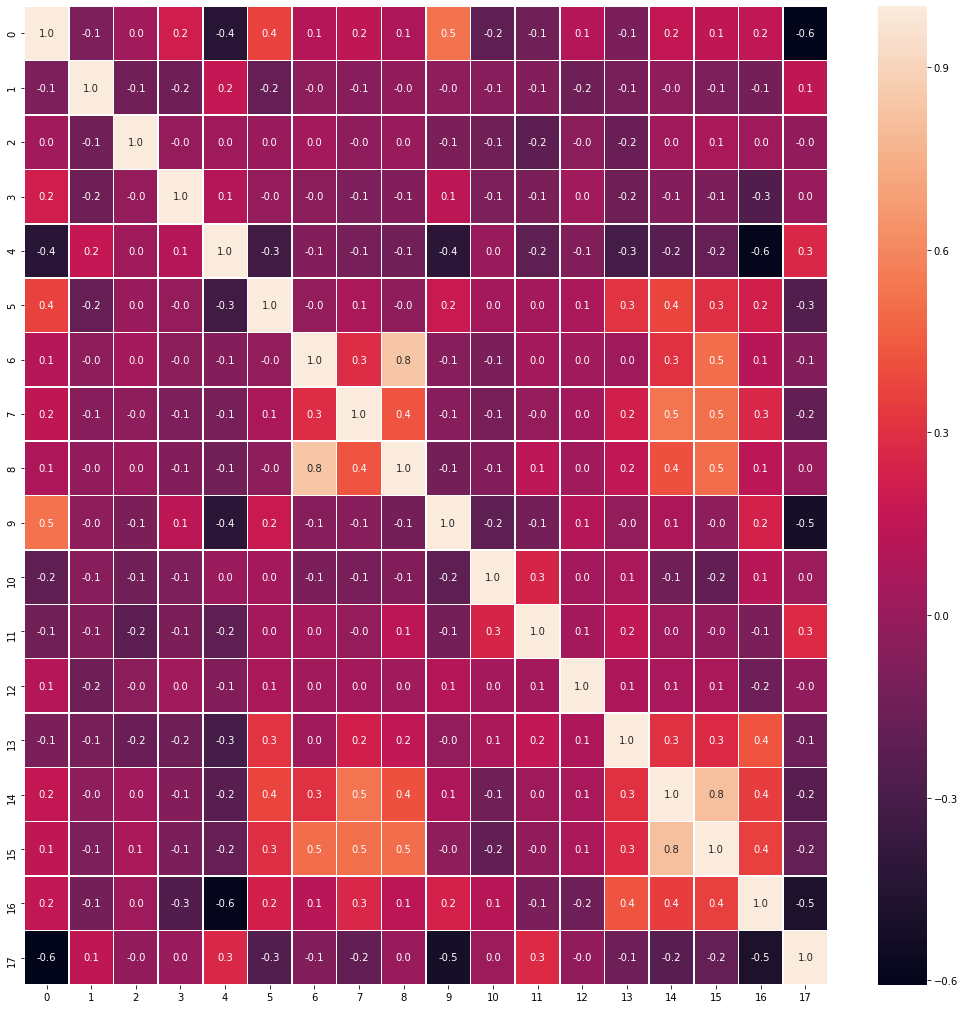

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pd.DataFrame(nor_numeric_X).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [184]:
remove_high_corr = nor_numeric_X[:,:17]
remove_high_corr_test = nor_numeric_test_X[:,:17]
train_X, test_X, train_y, test_y = train_test_split(remove_high_corr, y ,test_size = test_size, random_state = random_state)

In [30]:
learning_rate = [0.2, 0.1, 0.01, 0.001]
n_estimators = [50, 100, 200, 300, 500]
subsample = [0.25, 0.5, 0.75, 1]
min_samples_split = [2, 3, 4, 5, 8]
max_depth = [3, 4, 5, 8, 10, 20]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, 
                  min_samples_split=min_samples_split, max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = RandomizedSearchCV(gdbt, param_grid, n_jobs=-1, verbose=1, random_state=random_state)
grid_result = grid_search.fit(nor_numeric_X, y)
print("gdbt Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
gdbt Best Accuracy: 0.890244 using {'subsample': 0.5, 'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 5, 'learning_rate': 0.001}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.4s finished
D:\Tools\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [260]:
nor_numeric_test_X.shape

(33, 18)

In [266]:
test_features.shape

(33, 19)

In [31]:
best_gdbt = GradientBoostingClassifier(learning_rate=grid_result.best_params_['learning_rate'], 
                                       n_estimators=grid_result.best_params_['n_estimators'],
                                       subsample=grid_result.best_params_['subsample'],
                                       min_samples_split=grid_result.best_params_['min_samples_split'],
                                       max_depth=grid_result.best_params_['max_depth'], random_state = random_state)

best_gdbt.fit(nor_numeric_X, y)
best_gdbt_pred = best_gdbt.predict_proba(nor_numeric_test_X)[:,1]
sub = pd.DataFrame({'name': test_features.name, 'poi': best_gdbt_pred})
# sub['poi'] = sub['poi'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('drop_out_lier.csv', index=False)